In [4]:
import project_path
import os
import numpy as np
import json
from tqdm import tqdm
from typing import List, Dict, Any, Union, Tuple
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import pandas as pd

from attwizard.decoder import get_attention_representation
from attwizard.aligner import map_to_char_level
from attwizard.aligner import tokenize_char_level

from codeattention.source_code import SourceCode

from scipy.stats import spearmanr
from scipy.stats import kstest
from scipy.spatial.distance import jensenshannon

from attwizard.script.utils import read_data_in_parallel
from attwizard.script.utils import load_json_file

# EDA
from attwizard.visualizer.eda import visualize_corr_vs
from attwizard.visualizer.eda import visualize_code_heatmap_codegen
from attwizard.visualizer.eda import plot_histogram_in_parallel

# Goal
Here we study how well the followup and the competitor methods align with the ground truth code exploration.
We consider both CodeGen and GPT-J.

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
COMPARISON_FOLDER_CODEGEN = "cmp_v06"
OUT_PAPER_FOLDER = "../data/paper_figures"

In [7]:
RELEVANT_COMPARISONS = [
    'tl_top3_divide_all_dist_copycat',
    'tl_top3_divide_all_dist_followup',
    'tl_top3_divide_all_dist_gauss_neigh_1000',
    'tl_top3_divide_all_dist_humans',
    'tl_top3_divide_all_dist_naivemax',
    'tl_top3_divide_all_dist_naivemax_sym',
    'tl_top3_divide_all_dist_naivemean',
    'tl_top3_divide_all_dist_naivemean_sym',
    'tl_top3_divide_all_dist_raw_weights_first_layer',
    'tl_top3_divide_all_dist_raw_weights_last_layer',
    'tl_top3_divide_all_dist_raw_weights_first_layer_sym',
    'tl_top3_divide_all_dist_raw_weights_last_layer_sym',
    'tl_top3_divide_all_dist_rollout_condensed_all',
    'tl_top3_divide_all_dist_uniform',
]
regex = "|".join([n + "[^_]" for n in RELEVANT_COMPARISONS])
regex

'tl_top3_divide_all_dist_copycat[^_]|tl_top3_divide_all_dist_followup[^_]|tl_top3_divide_all_dist_gauss_neigh_1000[^_]|tl_top3_divide_all_dist_humans[^_]|tl_top3_divide_all_dist_naivemax[^_]|tl_top3_divide_all_dist_naivemax_sym[^_]|tl_top3_divide_all_dist_naivemean[^_]|tl_top3_divide_all_dist_naivemean_sym[^_]|tl_top3_divide_all_dist_raw_weights_first_layer[^_]|tl_top3_divide_all_dist_raw_weights_last_layer[^_]|tl_top3_divide_all_dist_raw_weights_first_layer_sym[^_]|tl_top3_divide_all_dist_raw_weights_last_layer_sym[^_]|tl_top3_divide_all_dist_rollout_condensed_all[^_]|tl_top3_divide_all_dist_uniform[^_]'

# CodeGen

In [8]:
model_dfs = [] 

for folder in [
        COMPARISON_FOLDER_CODEGEN, 
        #COMPARISON_FOLDER_GPTJ
        ]:
    # LOAD COMPARISON DATA
    path_comparison_dir = f'../data/comparisons/{folder}/'
    #available_comparisons = os.listdir(path_comparison_dir)
    #dfs = []
    dfs = read_data_in_parallel(
        base_folder=path_comparison_dir,
        file_type_extension='.csv',
        read_function=pd.read_csv,
        n_processes=20,
        extra_filter_regex=regex,
    )
    #for comparison in tqdm(available_comparisons):
    #    df = pd.read_csv(os.path.join(path_comparison_dir, comparison))
    #    dfs.append(df)
    df = pd.concat(dfs)
    all_comparisons = list(df["comparison_name"].unique())
    model_dfs.append(df)

df_codegen = model_dfs[0]
#df_gptj = model_dfs[1]



n of data read:  14


In [12]:
relevant_columns = [
    "comparison_name",
    "input_human_filestem",
    "input_machine_filestem",
    "top_3.token_index", 'top_3.value',
    'top_3.top_k_machine', 'top_3.top_k_groud_truth',
    'human_a', 'human_b', 
]

df_codegen_slim = df_codegen[relevant_columns]
# print the space occupied in memory
print(f"df_codegen_slim: {df_codegen_slim.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

df_codegen_slim: 939.95 MB


In [3]:
sorted(list(df_codegen["comparison_name"].unique()))

NameError: name 'df_codegen' is not defined

In [11]:
df_pos = df_codegen[df_codegen["comparison_name"] == "tl_top3_divide_all_dist_gauss_neigh_1000"]
df_fol = df_codegen[df_codegen["comparison_name"] == "tl_top3_divide_all_dist_followup"]
df_pos.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 149406 entries, ('tl_top3_divide_all_dist_gauss_neigh_1000', 0) to ('tl_top3_divide_all_dist_gauss_neigh_1000', 149405)
Data columns (total 43 columns):
 #   Column                                                     Non-Null Count   Dtype  
---  ------                                                     --------------   -----  
 0   comparison_name                                            149406 non-null  object 
 1   comparison_function                                        149406 non-null  object 
 2   source_code                                                149406 non-null  object 
 3   user_name                                                  149406 non-null  object 
 4   task_number                                                149406 non-null  int64  
 5   input_human_filestem                                       149406 non-null  object 
 6   input_machine_filestem                                     149406 non-null  obje

In [46]:
from ast import literal_eval

def create_compute_overlap(
        df: pd.DataFrame,
        column_a: str = 'top_3.top_k_machine_x',
        column_ground_truth_a: str = 'top_3.top_k_groud_truth_x',
        column_b: str = 'top_3.top_k_machine_y',
        column_ground_truth_b: str = 'top_3.top_k_groud_truth_y',
        col_name_for_undefined: str = ['top_3.value_x', 'top_3.value_y'],
        undefined_val: int = -1) -> pd.DataFrame:
    """Convert two columns to lists and compute their overlap.
    
    Note that this discsard all the records with 
    """
    df = df.copy()
    # drop all records with undefined values
    for col in col_name_for_undefined:
        df = df[df[col] != undefined_val]
    # convert columns to lists
    col_names_to_eval = [column_a, column_b, column_ground_truth_a, column_ground_truth_b]
    for col_name in col_names_to_eval:
        df[col_name] = df[col_name].apply(literal_eval)
    # # compute list overlap
    df["overlap_between_methods"] = df.apply(
        lambda row: len(set(row[column_a]).intersection(set(row[column_b]))), axis=1
    )
    def are_same_correct_prediction(row):
        """Check if the correct predictions are identical.
        
        Namely chek if the correct prediction of method a are the same as the
        correct prediction of method b."""
        # print("column_a:", row[column_a])
        # print("column_ground_truth_a:", row[column_ground_truth_a])
        # print("column_b:", row[column_b])
        # print("column_ground_truth_b:", row[column_ground_truth_b])
        
        correct_a = set(row[column_ground_truth_a]).intersection(set(row[column_a]))
        correct_b = set(row[column_ground_truth_b]).intersection(set(row[column_b]))
        # if len(correct_a) != 0 or len(correct_b) != 0:
        #     print("##################################################")
        # print("correct_a:", correct_a)
        # print("correct_b:", correct_b)
        assert set(row[column_ground_truth_a]) == set(row[column_ground_truth_b]), \
            "The ground truth should be the same for both methods."
        if correct_a == correct_b:
            return "identical"
        elif len(correct_a - correct_b) > 0:
            return "a has more"
        elif len(correct_b - correct_a) > 0:
            return "b has more"
        else:
            return "unclear"

    df = df.iloc[:1000]
    df["overlap_on_correct"] = df.apply(
        lambda row: are_same_correct_prediction(row), axis=1
    )
    return df



In [19]:
df_pos[df_pos['top_3.value'] > 0][["input_human_filestem", "input_machine_filestem", "top_3.token_index", 'top_3.value']].head()

input_human_filestem  \
tl_top3_divide_all_dist_gauss_neigh_1000 17               0480e5   
                                         18               0480e5   
                                         19               0480e5   
                                         21               0480e5   
                                         22               0480e5   

                                                                input_machine_filestem  \
tl_top3_divide_all_dist_gauss_neigh_1000 17  tree_Q2.py_0_Salesforce_codegen-16B-multi   
                                         18  tree_Q2.py_0_Salesforce_codegen-16B-multi   
                                         19  tree_Q2.py_0_Salesforce_codegen-16B-multi   
                                         21  tree_Q2.py_0_Salesforce_codegen-16B-multi   
                                         22  tree_Q2.py_0_Salesforce_codegen-16B-multi   

                                             top_3.token_index  top_3.value  
tl_top3_divide_all_dist_gauss_neigh_1000 17                 17            1  
                                         18                 18            1  
                                         19                 19            1  
                                         21                 21            1  
                                         22                 22            1

In [47]:
def compare_machine_overlaps(
        df_a, df_b, 
        merge_columns = [
            "input_human_filestem", "input_machine_filestem", "top_3.token_index"],
        ):
    """Compare overlap between two comparison dataframes."""
    # df_a = df_a[
    #     (df_a['input_human_filestem'] == '0480e5') &
    #     (df_a['top_3.token_index'] == 17) &
    #     (df_a['input_machine_filestem'] == 'tree_Q2.py_0_Salesforce_codegen-16B-multi')]
    # print(len(df_a))
    df_merged = pd.merge(df_a, df_b, on=merge_columns, how="inner", indicator=True)
    df_merged = create_compute_overlap(
        df=df_merged,
        column_a="top_3.top_k_machine_x",
        column_ground_truth_a="top_3.top_k_groud_truth_x",
        column_b="top_3.top_k_machine_y",
        column_ground_truth_b="top_3.top_k_groud_truth_y",
        col_name_for_undefined=['top_3.value_x', 'top_3.value_y'],
        )
    return df_merged

df_overlap = compare_machine_overlaps(
    df_a=df_pos, df_b=df_fol,
)

In [49]:
intresting_comparisons = [
    'tl_top3_divide_all_dist_copycat',
    'tl_top3_divide_all_dist_followup',
    'tl_top3_divide_all_dist_gauss_neigh_1000'
]
dfs = []
for comp_a in tqdm(intresting_comparisons):
    for comp_b in intresting_comparisons:
        if comp_a == comp_b:
            continue
        print(comp_a, comp_b)
        df_a = df_codegen[df_codegen["comparison_name"] == comp_a][[
            "comparison_name",
            "input_human_filestem", "input_machine_filestem", 
            "top_3.token_index", 'top_3.value',
            'top_3.top_k_machine', 'top_3.top_k_groud_truth']]
        df_b = df_codegen[df_codegen["comparison_name"] == comp_b][[
            "comparison_name",
            "input_human_filestem", "input_machine_filestem", 
            "top_3.token_index", 'top_3.value',
            'top_3.top_k_machine', 'top_3.top_k_groud_truth']]
        print(f"length {comp_a}:", len(df_a))
        print(f"length {comp_b}:", len(df_b))
        df_overlap = compare_machine_overlaps(
            df_a=df_a, df_b=df_b,
        )
        display(df_overlap.head())
        df_overlap = df_overlap[['comparison_name_x', 'comparison_name_y', 'overlap_on_correct']]
        dfs.append(df_overlap)

df_all_overlap = pd.concat(dfs)
df_all_overlap


  0%|          | 0/3 [00:00<?, ?it/s]

tl_top3_divide_all_dist_copycat tl_top3_divide_all_dist_followup
length tl_top3_divide_all_dist_copycat: 149406
length tl_top3_divide_all_dist_followup: 149406


,comparison_name_x,input_human_filestem,input_machine_filestem,top_3.token_index,top_3.value_x,top_3.top_k_machine_x,top_3.top_k_groud_truth_x,comparison_name_y,top_3.value_y,top_3.top_k_machine_y,top_3.top_k_groud_truth_y,_merge,overlap_on_correct
17,tl_top3_divide_all_dist_copycat,0480e5,tree_Q2.py_0_Salesforce_codegen-16B-multi,17,1,"[2, 54, 61]","[55, 57, 54]",tl_top3_divide_all_dist_followup,1,"[2, 57, 10]","[55, 57, 54]",both,a has more
18,tl_top3_divide_all_dist_copycat,0480e5,tree_Q2.py_0_Salesforce_codegen-16B-multi,18,0,"[2, 5, 6]","[55, 57, 54]",tl_top3_divide_all_dist_followup,1,"[2, 57, 10]","[55, 57, 54]",both,b has more
19,tl_top3_divide_all_dist_copycat,0480e5,tree_Q2.py_0_Salesforce_codegen-16B-multi,19,0,"[2, 61, 15]","[55, 57, 54]",tl_top3_divide_all_dist_followup,1,"[2, 57, 10]","[55, 57, 54]",both,b has more
21,tl_top3_divide_all_dist_copycat,0480e5,tree_Q2.py_0_Salesforce_codegen-16B-multi,21,0,"[30, 8, 24]","[55, 57, 54]",tl_top3_divide_all_dist_followup,1,"[2, 57, 10]","[55, 57, 54]",both,b has more
22,tl_top3_divide_all_dist_copycat,0480e5,tree_Q2.py_0_Salesforce_codegen-16B-multi,22,0,"[0, 18, 11]","[55, 57, 54]",tl_top3_divide_all_dist_followup,1,"[2, 57, 10]","[55, 57, 54]",both,b has more


tl_top3_divide_all_dist_copycat tl_top3_divide_all_dist_gauss_neigh_1000
length tl_top3_divide_all_dist_copycat: 149406
length tl_top3_divide_all_dist_gauss_neigh_1000: 0


  0%|          | 0/3 [00:04<?, ?it/s]


ValueError: Expected a 1D array, got an array with shape (0, 12)

In [29]:
df_overlap.head()

,comparison_name_x,comparison_function_x,source_code_x,user_name_x,task_number_x,input_human_filestem,input_machine_filestem,comparison_type_x,top_3_x,time_ts_sec_x,...,provenance.human.suffix_y,provenance.machine_y,top_3.value_y,top_3.top_k_groud_truth_y,top_3.top_k_machine_y,human_att_folder_y,machine_att_folder_y,_merge,overlap,overlap_on_correct
17,tl_top3_divide_all_dist_gauss_neigh_1000,top_3_overlap,tree_Q2.py,UbagU,2,0480e5,tree_Q2.py_0_Salesforce_codegen-16B-multi,matrix,NaN,1.664369e+09,...,_humans,"[{'subfolder': 'att_gaussian_neighbors_1000', ...",1,"[55, 57, 54]","[2, 57, 10]",./data/eye_tracking_attention/eye_v10,./data/model_output/exp_v10/codegen,both,1,identical
18,tl_top3_divide_all_dist_gauss_neigh_1000,top_3_overlap,tree_Q2.py,UbagU,2,0480e5,tree_Q2.py_0_Salesforce_codegen-16B-multi,matrix,NaN,1.664369e+09,...,_humans,"[{'subfolder': 'att_gaussian_neighbors_1000', ...",1,"[55, 57, 54]","[2, 57, 10]",./data/eye_tracking_attention/eye_v10,./data/model_output/exp_v10/codegen,both,1,identical
19,tl_top3_divide_all_dist_gauss_neigh_1000,top_3_overlap,tree_Q2.py,UbagU,2,0480e5,tree_Q2.py_0_Salesforce_codegen-16B-multi,matrix,NaN,1.664369e+09,...,_humans,"[{'subfolder': 'att_gaussian_neighbors_1000', ...",1,"[55, 57, 54]","[2, 57, 10]",./data/eye_tracking_attention/eye_v10,./data/model_output/exp_v10/codegen,both,1,identical
21,tl_top3_divide_all_dist_gauss_neigh_1000,top_3_overlap,tree_Q2.py,UbagU,2,0480e5,tree_Q2.py_0_Salesforce_codegen-16B-multi,matrix,NaN,1.664369e+09,...,_humans,"[{'subfolder': 'att_gaussian_neighbors_1000', ...",1,"[55, 57, 54]","[2, 57, 10]",./data/eye_tracking_attention/eye_v10,./data/model_output/exp_v10/codegen,both,1,identical
22,tl_top3_divide_all_dist_gauss_neigh_1000,top_3_overlap,tree_Q2.py,UbagU,2,0480e5,tree_Q2.py_0_Salesforce_codegen-16B-multi,matrix,NaN,1.664369e+09,...,_humans,"[{'subfolder': 'att_gaussian_neighbors_1000', ...",1,"[55, 57, 54]","[2, 57, 10]",./data/eye_tracking_attention/eye_v10,./data/model_output/exp_v10/codegen,both,1,identical


Text(0.5, 1.0, 'Overlap on correct predictions\nA=Position, B=Followup')

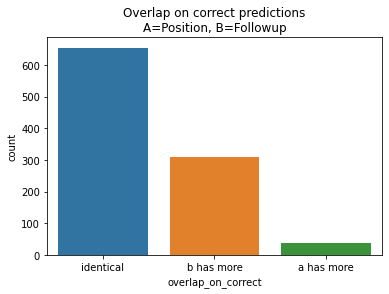

In [32]:
sns.countplot(
    data=df_overlap,
    x="overlap_on_correct",
)
plt.title("Overlap on correct predictions\nA=Position, B=Followup")

# Token visibility data
Get for each developer session the info on how long each token was visible for a given human.
These visibility time will become the weight to use in the WEIGHTED histogram.

In [6]:
# LOAD THE TOKEN INFORMATION
HUMAN_ATT_ON_CODEGEN_TOKENS_METADATA_FODLER = '../data/eye_tracking_attention/eye_v10/att_weights_Salesforce_codegen-16B-multi/metadata'
codegen_tokens = read_data_in_parallel(
    base_folder=HUMAN_ATT_ON_CODEGEN_TOKENS_METADATA_FODLER,
    file_type_extension='.json',
    read_function=load_json_file
)
all_tokens = [v for k, v in codegen_tokens.items()]
# flattent the list
all_tokens = [item for sublist in all_tokens for item in sublist]
df_tokens = pd.DataFrame.from_records(all_tokens)
# compute the total time spent in each session to normalize the weights
df_total_times = df_tokens.groupby('id').agg({'w': 'sum'}).reset_index()
df_total_times.rename(columns={'w': 'total_time'}, inplace=True)
# join the two tables and compute the percentage of total time with column w and column total_time
df_tokens_w_time = df_tokens.merge(df_total_times, on='id')
df_tokens_w_time['n_replicas_abs'] = df_tokens_w_time['w'].astype(int)
df_tokens_w_time['perc_time'] = df_tokens_w_time['w'] / df_tokens_w_time['total_time']
df_tokens_w_time['n_replicas_perc'] = df_tokens_w_time['perc_time'].apply(
    lambda x: round(x * 1000))
# rename the columns to join
df_tokens_w_time.rename(columns={
    'id': 'input_human_filestem',
    'i': 'token_index'}, inplace=True)
df_tokens_w_time.head()

n of data read:  92


,s,token_index,c,l,t,w,model,input_human_filestem,total_time,n_replicas_abs,perc_time,n_replicas_perc
0,0,0,0,0,#,0.0,Salesforce/codegen-16B-multi,0480e5,6607.23048,0,0.0,0
1,1,1,1,0,********************************,0.0,Salesforce/codegen-16B-multi,0480e5,6607.23048,0,0.0,0
2,34,2,34,0,********************************,0.0,Salesforce/codegen-16B-multi,0480e5,6607.23048,0,0.0,0
3,66,3,66,0,********,0.0,Salesforce/codegen-16B-multi,0480e5,6607.23048,0,0.0,0
4,74,4,74,0,***,0.0,Salesforce/codegen-16B-multi,0480e5,6607.23048,0,0.0,0


In [7]:
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=False)

def enrich_with_time_weights(df, df_tokens_w_time, short_col_name: str):
    """Add the column telling how long a human spent on a FROM token"""
    # enrich the dataset with the token position and replicate the 
    # records depending on how much time the user spent on that starting
    # token
    df_tokens_w_time_copy = df_tokens_w_time
    df_tokens_w_time_copy = df_tokens_w_time_copy.rename(columns={
        'input_human_filestem': 'unified_input_human_filestem',
        'token_index': f'{short_col_name}.token_index'})
    # check that human_a is not null
    df['unified_input_human_filestem'] = df.parallel_apply(
        lambda row: row['human_a'] 
            if ('human_a' in row.keys() and row['human_a'] is not None and not pd.isna(row['human_a']))
            else row['input_human_filestem'],
        axis=1
    )
    #display(df[['unified_input_human_filestem', 'human_a', 'input_human_filestem']].head())
    #df.info()
    #df_tokens_w_time_copy.info()
    # if 'human_a' in df.columns:
    #     len_input_human_filestem = df[
    #         'input_human_filestem'].notnull().sum()
    #     len_column_human_a = df[
    #         'human_a'].notnull().sum()
    #     if len_column_human_a > len_input_human_filestem:
    #         # drop the column input_human_filestem
    #         df = df.drop(
    #             columns=['input_human_filestem'])
    #         df = df.rename(columns={
    #             'human_a': 'input_human_filestem'})
    df = df.merge(
        df_tokens_w_time_copy,
        on=['unified_input_human_filestem', f'{short_col_name}.token_index'], 
        how='left')
    return df


def replicated_based_on_weights(df, weight_column_name: str):
    """Replicate the records based on the weight column"""
    df = df.reset_index(drop=True)
    # repeat the rows based on the integer weight contained in the column
    # weights_column_name
    df = df.reindex(df.index.repeat(df[weight_column_name]))
    df = df.reset_index(drop=True)
    #df = df.loc[
    #    np.repeat(df.index.values, df[weight_column_name])]
    return df


def replicated_based_on_token_visibility(
        df, 
        df_tokens_w_time,
        short_col_name: str,
        weight_column_name: str):
    """Replicate the records based on the weight column"""
    df = enrich_with_time_weights(df, df_tokens_w_time, short_col_name)
    df = replicated_based_on_weights(df, weight_column_name)
    return df

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Agreement: Interaction Matrix

1. Base distribution: based on distance: `eye_v10/decay_0.1_Salesforce_codegen-16B-multi/data_avg_followup/df_base_all_prob_based_on_distance.csv`
1. Normalization operation: divide
1. How to avoid zeros in base distribution: sum 0.00001 to all the distribution
1. Weight the comparison baased on the time (in seconds) spent by the developer on that record. 
1. Cap the maximum value to 10 seconds, to avoid long stared records to have too much weight.

In [8]:
# the maximum allowed replication of each record, even if the token is looked
# at for a long time
MAX_TIME_WEIGHT = 10

df_tokens_w_time['percn_replicas_abs'] = df_tokens_w_time['n_replicas_abs'].apply(
    lambda x: min(x, MAX_TIME_WEIGHT))

In [9]:
# Naming conversion
naming_mapping = {
 '_divide_all_dist_gauss_neigh_1000': 'Position (σ=1000)',
#  '_divide_all_dist_copycat': 'Copy-cat',
#  '_divide_all_dist_followup': 'Follow-up att.',
#  '_divide_all_dist_gauss_neigh_200': 'Position (σ=200)',
#  '_divide_all_dist_gauss_neigh_30': 'Position (σ=30)',
#  '_divide_all_dist_gauss_neigh_400': 'Position (σ=400)',
#  '_divide_all_dist_humans': 'Devs vs devs',
#  '_divide_all_dist_naivemax': 'Max att.',
#  '_divide_all_dist_naivemax_sym': 'Max att. (sym.)',
#  '_divide_all_dist_naivemean': 'Mean att.',
#  '_divide_all_dist_naivemean_sym': 'Mean att. (sym.)',
#  '_divide_all_dist_raw_weights_first_layer': 'Raw att. (1st layer)',
#  '_divide_all_dist_raw_weights_last_layer': 'Raw att. (last layer)',
#  '_divide_all_dist_raw_weights_first_layer_sym': 'Raw att. (1st) (sym.)',
#  '_divide_all_dist_raw_weights_last_layer_sym': 'Raw att. (last) (sym.)',
#  '_divide_all_dist_rollout_condensed_all': 'Rollout att.',
#  '_divide_all_dist_uniform': 'Uniform',
}

def map_nl_name_to_color(natural_language_name): 
    if 'att.' in natural_language_name:
        return 'lightcoral'
    elif 'devs' in natural_language_name:
        return 'limegreen'
    else:
        return 'skyblue'

colors_mapping = {
    k: map_nl_name_to_color(v) for k, v in naming_mapping.items()}

In [10]:
colors_mapping

{'_divide_all_dist_gauss_neigh_1000': 'skyblue'}

## Spearman Correlation


In [35]:
df = df_codegen[
    (df_codegen['comparison_name'].str.contains('tl_spearman')) &
    ~(df_codegen['comparison_name'].str.contains('pair')) & 
    ~(df_codegen['comparison_name'].str.contains('followup_max'))]

# drop all meaningless comparisons (the correlation was not defined)
df = df[df["spearman_res.corr"] != -1]

# augment the dataset with the time weights
df = replicated_based_on_token_visibility(
    df=df, 
    df_tokens_w_time=df_tokens_w_time.copy(), 
    short_col_name='spearman_res',
    weight_column_name='n_replicas_abs')
df = df.reset_index(drop=True)
df_spearman = df

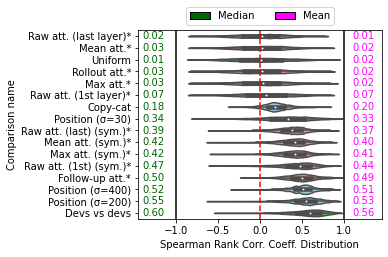

In [40]:
from matplotlib.patches import Patch

means = df_spearman.groupby('comparison_name')['spearman_res.corr'].mean()
medians = df_spearman.groupby('comparison_name')['spearman_res.corr'].median()

fig, ax = plt.subplots(figsize=(5.5, 3.7))

names_as_display_order = means.sort_values().index
palette = {
    "tl_spearman" + k: v for k, v in colors_mapping.items()}
nl_mapping = {
    "tl_spearman" + k: v for k, v in naming_mapping.items()}

sns.violinplot(
    data=df_spearman,
    x="spearman_res.corr",
    y="comparison_name",
    order=names_as_display_order,
    palette=palette,
    ax=ax
)
for i, name in enumerate(names_as_display_order):
    ax.text(
        -1.40, i + 0.25, f"{medians[name]:.2f}", color='darkgreen')
    ax.text(
        1.1, i + 0.25, f"{means[name]:.2f}", color='magenta')

# replace the labels with the natural language names
ax.set_yticklabels([
    nl_mapping[n] + '*'
    if "att." in nl_mapping[n] else nl_mapping[n]
    for n in names_as_display_order])

#plt.setp(ax.collections, alpha=.3)
#plt.scatter(y=range(len(means)), x=means, color='red', marker='o')
#plt.scatter(y=range(len(medians)), x=medians, color='darkgreen', marker='X')
# vertical line on -1 and +1
ax.axvline(x=-1, color='black')
ax.axvline(x=1, color='black')
# red in zero
ax.axvline(x=0, color='red', linestyle='--')
ax.set_xlabel("Spearman Rank Corr. Coeff. Distribution")
ax.set_ylabel("Comparison name")
plt.xlim(-1.45, 1.45)

# add legend with magenta and green patches
legend_elements = [
    Patch(facecolor='darkgreen', edgecolor='black', label='Median'),
    Patch(facecolor='magenta', edgecolor='black', label='Mean'),]
# position the legend above outside the plot
ax.legend(
    handles=legend_elements, loc='upper center', 
    bbox_to_anchor=(0.5, 1.15), ncol=2)

plt.tight_layout()
fig.savefig(
    os.path.join(OUT_PAPER_FOLDER, "tl_spearman_all_comparisons.pdf"))

## Top-K

In [11]:
df = df_codegen[
    (df_codegen['comparison_name'].str.contains('tl_top3')) &
    ~(df_codegen['comparison_name'].str.contains('pair')) & 
    ~(df_codegen['comparison_name'].str.contains('followup_max'))]

col_name = "top_3.value"
# remove invalid comparisons
df = df[df[col_name] != -1]
# convert col_name to string
df[col_name] = df[col_name].astype(int).astype(str)
# weight the datapoint for the time spent on the starting token
df = replicated_based_on_token_visibility(
    df=df,
    df_tokens_w_time=df_tokens_w_time.copy(), 
    short_col_name='top_3',
    weight_column_name='n_replicas_abs')
df = df.reset_index(drop=True)
df_top3 = df

/home/eaftan/copilot-attention/attwizard/visualizer/eda.py:275: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


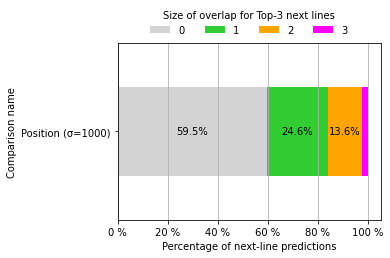

In [12]:

from attwizard.visualizer.eda import plot_100_perc_stacked_bar

nl_mapping = {
    "tl_top3" + k: v for k, v in naming_mapping.items()}

# sort based on the percentage of zeros for each group
ascending_order = df_top3.groupby('comparison_name')['top_3.value'].value_counts(normalize=True).loc[:, '0'].sort_values().index

fig, ax = plot_100_perc_stacked_bar(
    df=df_top3,
    col_name_group="comparison_name",
    col_name_category_in_group=col_name,
    direction='horizontal',
    group_order=ascending_order,
    #group_order=sorted(names_as_display_order, reverse=True),
    n_cols_legend=4,
    # color balck, limegree, 
    fmt='{:.1%}',
    color=['lightgray', 'limegreen', 'orange', 'magenta'],
    legend_title='Size of overlap for Top-3 next lines'
)

# replace the labels with the natural language names
ax.set_yticklabels([
    nl_mapping[n] + '*'
    if "att." in nl_mapping[n] else nl_mapping[n]
    for n in ascending_order
])

ax.set_xlabel("Percentage of next-line predictions")
ax.set_ylabel("Comparison name")
fig.set_size_inches(5.5, 3.7)
plt.tight_layout()

fig.savefig(
    os.path.join(OUT_PAPER_FOLDER, "tl_top3_all_comparisons.pdf"))